In [1]:
import sys
sys.path.append("../src/")
import integration as itg
import mittag_leffler as ml
import utils as ut
import matplotlib.pyplot as plt
import numpy as np

data_path = "../data/"

# Fractional Langevin equation

Particle accelerated by the effect of a random force and a fractional dissipative term
 
$$
M\frac{d^2 q(t)}{dt^2} + M \eta_0 D^{\beta}_t q(t) = \xi(t)
$$

Using the Laplace tranform, it is obtained the following set of solutions:

$$
q(t) = \frac{1}{M} [ f(t) \ast t E_{2-\beta, 2}\left( -\eta_0 t^{2-\beta} \right)\\ + Mq'(0) E_{2-\beta, 2}\left( -\eta_0 t^{2-\beta} \right)\\ + Mq(0) E_{2-\beta, 1}\left( -\eta_0 t^{2-\beta} \right)\\ + b_0(t)]
$$

In [2]:
def line(t):
    return t

def solution_sde(t, noise, x0, v0):
    t_ = np.array(t)
    noise_ = np.array(noise)
    return x0 + v0*t_ + itg.convolution(line, noise_, t_)

In [3]:
def solution_fle_white(t, noise, order, v0):
	t__ = np.array(t)
	noise__ = np.array(noise)
	def nonlinear_term(t):
		z = -t**(2-order)
		return t * ml.mittag_leffler_vector(z, 2-order, 2)
	conv = itg.convolution(nonlinear_term, noise__, t__)
	nonlinear = v0 * nonlinear_term(t__)
	return nonlinear + conv

In [4]:
final_time = 30
noise_steps = 1
x0 = 0
v0 = 0

In [9]:
def plot_results(h, times, percentage = 1):
    fd_order = 2 - 2*h
    final_time = 30
    fig, ax = plt.subplots(1,len(times), figsize = (15, 5))
    for i in range(len(times)):
        df_ns1 = ut.read_hdf5_data(data_path + f"fle-h-{h}-noise{times[i]}.hdf5")
        df_sol1 = ut.read_hdf5_data(data_path + f"fle-h-{h}-{times[i]}-v00.hdf5")
        N = len(df_ns1)
        delta_t = final_time/N
        if len(times) == 1:
            axi = ax
        else:
            axi = ax[i]
        t = df_ns1.deets_t
        noise = df_ns1.deets_v
        fg = solution_sde(t, noise, x0, v0)
        anl = solution_fle_white(t, noise, fd_order, fg[2]/delta_t)
        t_sol = df_sol1.deets_t
        sol = df_sol1.deets_v
        N = int(percentage*len(sol))
        
        axi.plot(t_sol[:N], sol[:N], marker = "^", ls = "")
        axi.plot(t[:N], anl[:N])
        axi.set_xlabel("Time")
        axi.set_ylabel("Position")
    fig.tight_layout()

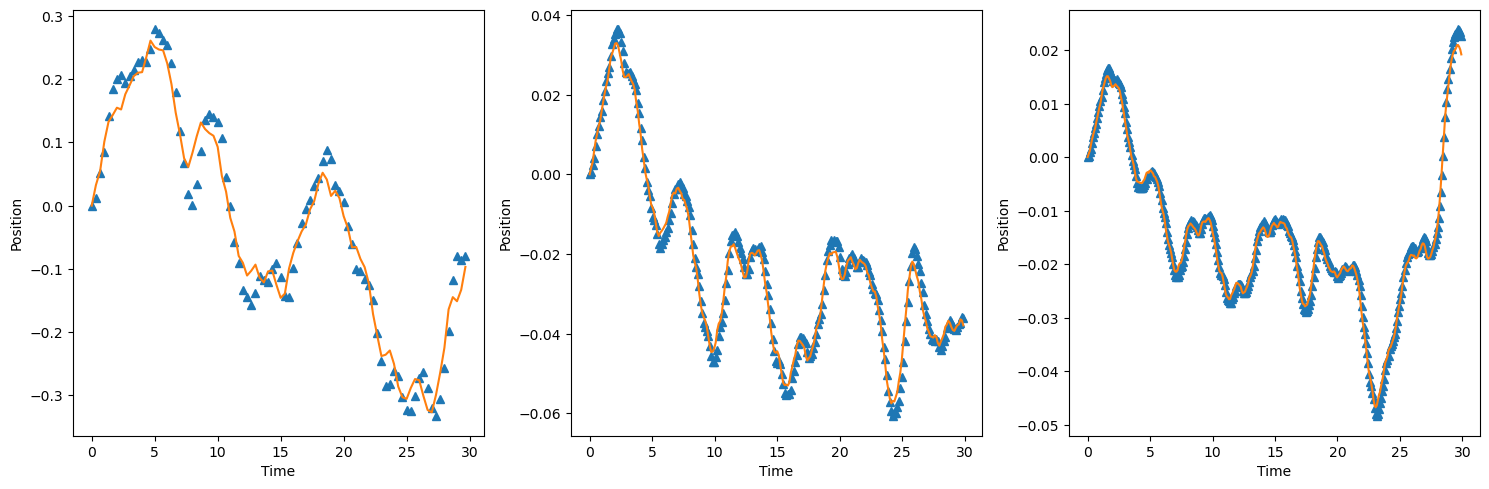

In [10]:
h = 0.6
times = [90, 250, 350]
plot_results(h, times)


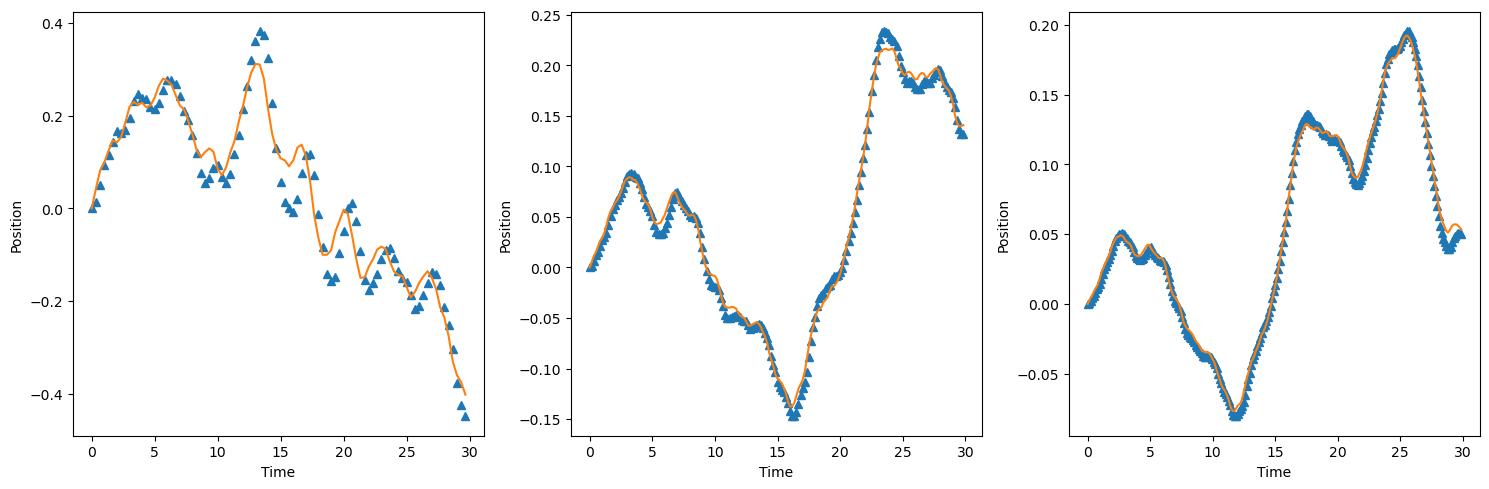

In [11]:
h = 0.7
times = [90, 180, 250]
plot_results(h, times)

h = 4

<table>
<tr>
<td>
<img src="inspect_benchmark2_fle_files/fle_h=0.4-N90-anl.png" width="400" />
</td>
<td>
<img src="inspect_benchmark2_fle_files/fle_h=0.4-N250-anl.png" width="400" />
</td>
<td>
<img src="inspect_benchmark2_fle_files/fle_h=0.4-N350-anl.png" width="400" />
</td>
</tr>
</table>